In [8]:
# load dataset
import pandas as pd
from sklearn.datasets import load_diabetes

dataset = load_diabetes()

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
df['target'] = dataset.target

# EDA
print('5 data teratas')
print(df.head(), '\n')

print('info dataset')
print(df.info(), '\n')

print('cek missing values')
print(df.isnull().sum())

5 data teratas
        age       sex       bmi        bp        s1        s2        s3  \
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401   
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  target  
0 -0.002592  0.019907 -0.017646   151.0  
1 -0.039493 -0.068332 -0.092204    75.0  
2 -0.002592  0.002861 -0.025930   141.0  
3  0.034309  0.022688 -0.009362   206.0  
4 -0.002592 -0.031988 -0.046641   135.0   

info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     442 non-null    float64
 1   sex     442 non-null    float64
 2   bmi     4

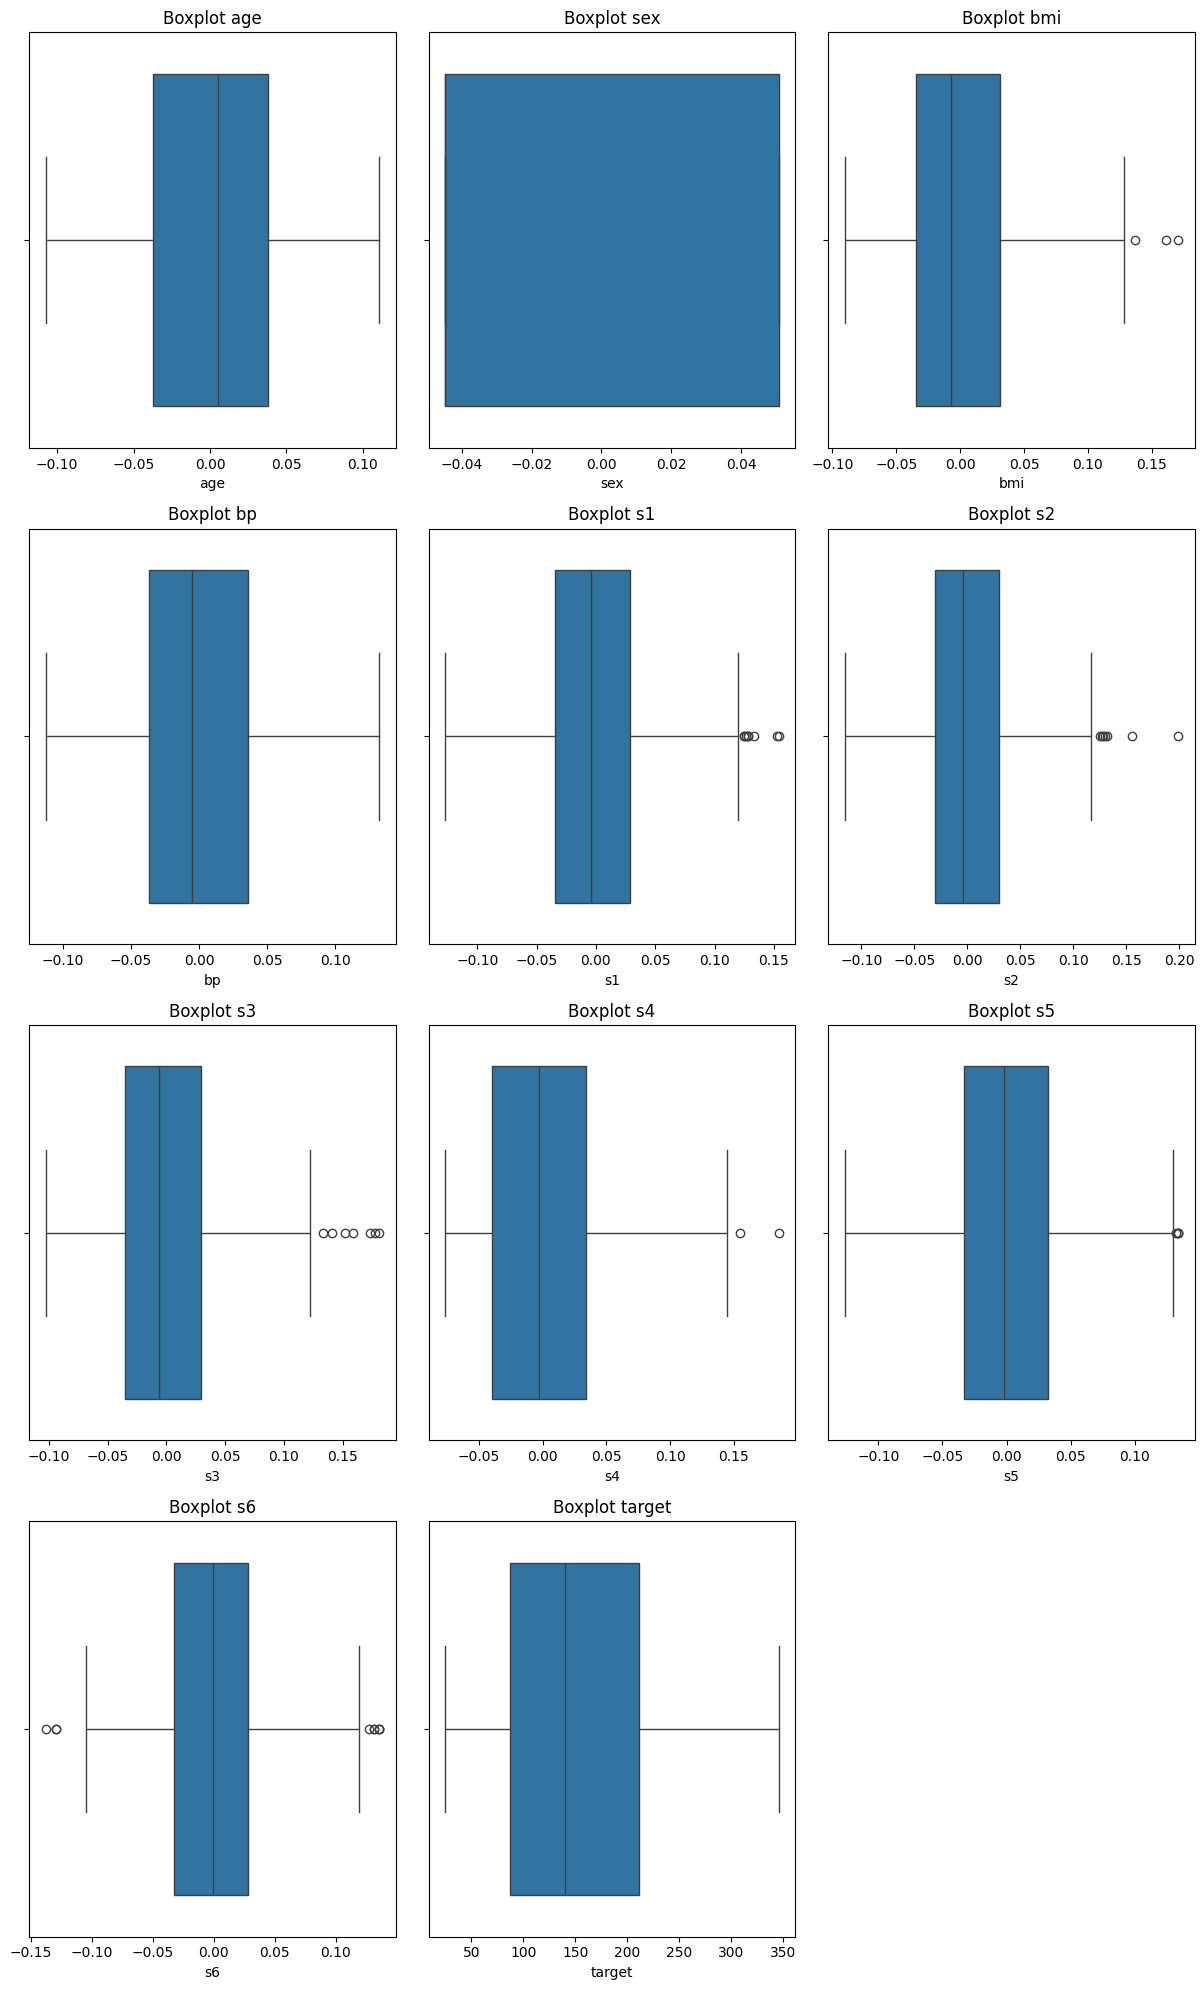

In [9]:
# Cek outlier
import seaborn as sns 
import matplotlib.pyplot as plt

# ambil semua kolom numerik otomatis
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
rows = len(numeric_cols) // 3 + 1  # Bagi jadi beberapa baris
cols = 3  # Misalnya 3 kolom biar rapi

plt.figure(figsize=(cols * 4, rows * 5))

for i, col in enumerate(numeric_cols):
    plt.subplot(rows, cols, i + 1)  # Atur jumlah baris dan kolom
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

# fitur yang mempunyai outlier
# 1. bmi, s1, s2, s3, s4, s5, s6

Outlier berhasil dicapping!


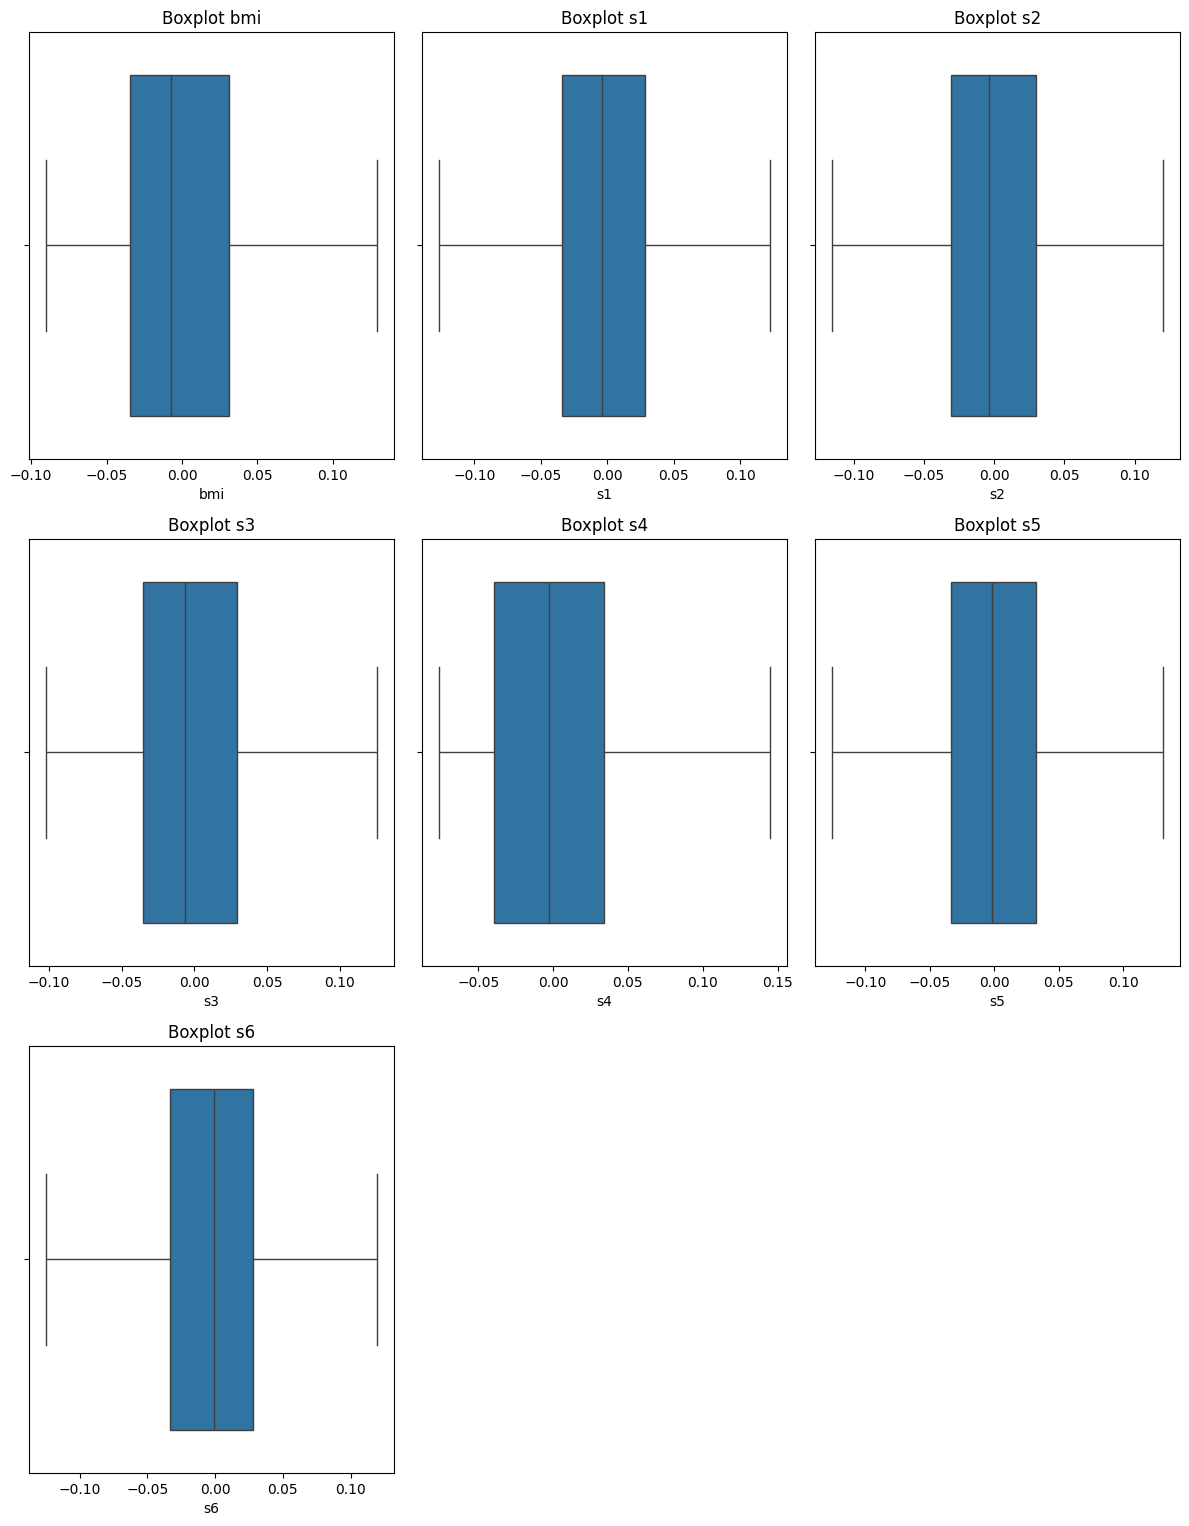

In [10]:
# handle outlier
import numpy as np

# Fungsi capping outlier
def cap_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping
        df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

    return df

# List fitur yang mau di-handle
outlier_cols = ['bmi', 's1', 's2', 's3', 's4', 's5', 's6']

# Panggil fungsi buat capping
df = cap_outliers(df, outlier_cols)

print('Outlier berhasil dicapping!')

rows = len(numeric_cols) // 3 + 1  # Bagi jadi beberapa baris
cols = 3  # Misalnya 3 kolom biar rapi

plt.figure(figsize=(cols * 4, rows * 5))

for i, col in enumerate(outlier_cols):
    plt.subplot(rows, cols, i + 1)  # Atur jumlah baris dan kolom
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

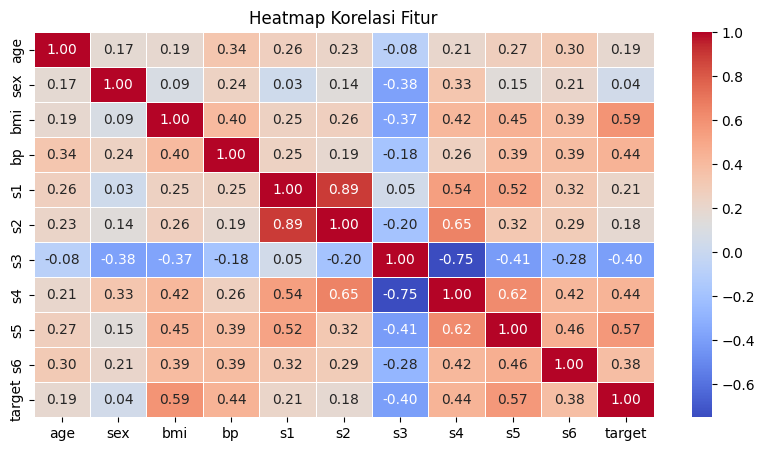

In [11]:
# heatmap korelasi 

# filter hanya kolom numerik
df_numeric = df.select_dtypes(include=['number'])

# cek korelasi
plt.figure(figsize=(10, 5))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Heatmap Korelasi Fitur')
plt.show()

In [51]:
# preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Buat fitur interaksi
df['bmi_s5_interaction'] = df['bmi'] * df['s5']
df['bmi_bp_ratio'] = df['bmi'] / df['bp']
df['s1_s2_sum'] = df['s1'] + df['s2']

# Pisahkan fitur dan target
X = df.drop(columns=['target'])
y = df['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection pake SelectKBest
from sklearn.feature_selection import SelectKBest, f_regression
skb = SelectKBest(score_func=f_regression, k=10)
X_train = skb.fit_transform(X_train, y_train)
X_test = skb.transform(X_test)

# Scaling
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)



In [55]:
# RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
rfe = RFE(estimator=lr, n_features_to_select=10)
X_train_rfe = rfe.fit_transform(X_train_ss, y_train)
X_test_rfe = rfe.transform(X_test_ss)

# Ambil nama kolom dari dataframe awal
selected_features = X.columns[rfe.support_]
print(selected_features)

# Cek ranking fitur
ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
print(ranking.sort_values(by='Ranking'))


IndexError: boolean index did not match indexed array along axis 0; size of axis is 13 but size of corresponding boolean axis is 10

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ambil fitur terpilih hasil RFE
selected_features = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

X_train_rfe = X_train_ss[:, :len(selected_features)]
X_test_rfe = X_test_ss[:, :len(selected_features)]

# Modeling
lr = LinearRegression()
lr.fit(X_train_rfe, y_train)

# Prediksi
y_pred = lr.predict(X_test_rfe)

# Evaluasi
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")


MSE: 2905.863218105173
MAE: 42.6119003857969
R2: 0.4515326559080214
